# Fog Data

In [2]:
import requests
from xml.etree import ElementTree as ET

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import anderson
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import os   

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## DATASET

In [65]:
raw_fog = pd.read_csv(f'C:/Users/USER/DATA WORK PLACE/2. DATA STUDY/6. WEATHER/data/fog_train.csv', encoding = 'euc-kr')
fog_test = pd.read_csv(f'C:/Users/USER/DATA WORK PLACE/2. DATA STUDY/6. WEATHER/data/fog_test.csv', encoding = 'euc-kr')

raw_fog

,Unnamed: 0,fog_train.year,fog_train.month,fog_train.day,fog_train.time,fog_train.minute,fog_train.stn_id,fog_train.ws10_deg,fog_train.ws10_ms,fog_train.ta,fog_train.re,fog_train.hm,fog_train.sun10,fog_train.ts,fog_train.vis1,fog_train.class
0,1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
3,4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
4,5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,3156455,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4
3156455,3156456,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4
3156456,3156457,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4
3156457,3156458,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4


In [66]:
fog_test

,fog_test.year,fog_test.month,fog_test.day,fog_test.time,fog_test.minute,fog_test.stn_id,fog_test.ws10_deg,fog_test.ws10_ms,fog_test.ta,fog_test.re,fog_test.hm,fog_test.sun10,fog_test.ts,fog_test.class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
3,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
4,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,L,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9,NaN
262796,L,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9,NaN
262797,L,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8,NaN
262798,L,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4,NaN


In [67]:
def raw_data_preprocessing_train(dataset):

    fog_data = dataset.copy()

    fog_data = fog_data.drop(['Unnamed: 0'], axis = 1)

    fog_data = fog_data.replace(-99.00, np.NaN)
    fog_data = fog_data.replace(-99.90, np.NaN)

    columns = fog_data.columns
    columns = [column.replace('fog_train.', "") for column in columns]
    fog_data.columns = columns

    return fog_data

def raw_data_preprocessing_test(dataset):

    fog_data = dataset.copy()

    fog_data = fog_data.replace(-99.00, np.NaN)
    fog_data = fog_data.replace(-99.90, np.NaN)

    columns = fog_data.columns
    columns = [column.replace('fog_test.', "") for column in columns]
    fog_data.columns = columns
    fog_data = fog_data.drop(['class'], axis = 1)

    return fog_data

In [68]:
fog_data = raw_data_preprocessing_train(raw_fog)

fog_data = fog_data.drop(['year', 'minute', 'day', 'vis1'], axis = 1)

fog_test = raw_data_preprocessing_test(fog_test)

fog_test = fog_test.drop(['year', 'day', 'minute'], axis = 1)

fog_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,1,0,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0
1,1,0,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0
2,1,0,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0
3,1,0,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0
4,1,0,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0
3156455,12,23,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0
3156456,12,23,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0
3156457,12,23,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0


In [69]:
fog_test

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,1,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,1,0,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,1,0,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,1,0,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,1,0,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...
262795,12,23,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9
262796,12,23,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9
262797,12,23,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8
262798,12,23,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4


### [전처리] 컬럼 추가

#### 결측치 제거(class 컬럼)

In [70]:
fog_data = fog_data.dropna(subset = ['class'])

#### 결측치 보간(기타 컬럼)

In [71]:
fog_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,1,0,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0
1,1,0,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0
2,1,0,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0
3,1,0,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0
4,1,0,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0
3156455,12,23,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0
3156456,12,23,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0
3156457,12,23,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0


In [72]:
fog_data = fog_data.dropna()
fog_test = fog_test.interpolate(method = 'quadratic', limit_direction = 'both')

C:\Users\USER\AppData\Local\Temp\ipykernel_3504\1227435585.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fog_test = fog_test.interpolate(method = 'quadratic', limit_direction = 'both')


In [73]:
fog_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,1,0,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0
1,1,0,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0
2,1,0,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0
3,1,0,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0
4,1,0,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0
3156455,12,23,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0
3156456,12,23,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0
3156457,12,23,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0


#### 지역 컬럼 레이블링

In [74]:
def labelencoding_for_territory(dataset):

    stn_list = dataset['stn_id'].str[0]

    dataset['stn_id'] = stn_list

    stn_encoding_df = pd.DataFrame({
        'stn_id' : ['A', 'B', 'C', 'D', 'E'],
        'stn_num' : [1, 2, 3, 4, 5]
    })

    stn_encoding_map = stn_encoding_df.set_index('stn_id')['stn_num'].to_dict()
    # df를 series로 만든 후 dict형태로 변환하기
    dataset['stn_id'] = dataset['stn_id'].map(stn_encoding_map)
    return dataset

In [75]:
fog_data = labelencoding_for_territory(fog_data)
fog_test = labelencoding_for_territory(fog_test)

C:\Users\USER\AppData\Local\Temp\ipykernel_3504\3368638078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['stn_id'] = stn_list
C:\Users\USER\AppData\Local\Temp\ipykernel_3504\3368638078.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['stn_id'] = dataset['stn_id'].map(stn_encoding_map)


#### 이슬점 고려

In [76]:
fog_test

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,1,0,1,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,1,0,1,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,1,0,1,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,1,0,1,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,1,0,1,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...
262795,12,23,5,338.8,6.1,4.5,0.0,71.3,0.0,1.9
262796,12,23,5,335.2,5.8,4.6,0.0,71.4,0.0,1.9
262797,12,23,5,337.1,5.3,4.5,0.0,72.1,0.0,1.8
262798,12,23,5,322.0,3.7,4.3,0.0,72.5,0.0,1.4


In [77]:
def dew_point(df):
    
    data = df.copy()

    a = 17.27
    b = 237.7
    
    T = data['ta']
    RH = data['hm']
    gamma = (a * T) / (b + T) + np.log(RH / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    
    data['dew_point'] = dew_point
    
    return data

In [78]:
def dew_reach_column(df):
    
    data = df.copy()

    dew_re_list = []
    for i in range(len(data)):
        if data['ts'].values[i] < data['dew_point'].values[i]:
            dew_re_list.append(1)
        else:
            dew_re_list.append(0)
    data['dew_reached'] = dew_re_list
    
    data = data.drop(['dew_point'], axis = 1)
    
    return data


In [79]:
fog_data = dew_point(fog_data)
fog_test = dew_point(fog_test)

fog_data

c:\Users\USER\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,dew_point
0,1,0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,-18.083476
1,1,0,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,-18.299136
2,1,0,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,-17.664937
3,1,0,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,-17.722897
4,1,0,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,-17.543307
...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,-6.810493
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,-7.021146
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,-6.882689
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,-6.798347


In [80]:
fog_data = dew_reach_column(fog_data)
fog_test = dew_reach_column(fog_test)

fog_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,dew_reached
0,1,0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,0
1,1,0,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,0
2,1,0,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,0
3,1,0,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,0
4,1,0,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,0
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,0
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,0


In [81]:
fog_test

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_reached
0,1,0,1,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,0
1,1,0,1,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,0
2,1,0,1,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,0
3,1,0,1,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,0
4,1,0,1,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,0
...,...,...,...,...,...,...,...,...,...,...,...
262795,12,23,5,338.8,6.1,4.5,0.0,71.3,0.0,1.9,0
262796,12,23,5,335.2,5.8,4.6,0.0,71.4,0.0,1.9,0
262797,12,23,5,337.1,5.3,4.5,0.0,72.1,0.0,1.8,0
262798,12,23,5,322.0,3.7,4.3,0.0,72.5,0.0,1.4,0


#### 지상-지면온도차

In [82]:
fog_data['diff'] = fog_data['ta'] - fog_data['ts']
fog_test['diff'] = fog_test['ta'] - fog_test['ts']
fog_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,dew_reached,diff
0,1,0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,0,-3.6
1,1,0,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,0,-3.6
2,1,0,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,0,-3.7
3,1,0,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,0,-3.6
4,1,0,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,0,-3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,0,3.4
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,0,3.6
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,0,3.6
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,0,3.7


#### 일사량 1보다 큰 값 100으로 치환

In [83]:
def sun_100(data):
    data['sun10'] = data['sun10'].apply(lambda x: 100 if x >= 1 else x)
    return data

In [84]:
fog_data = sun_100(fog_data)
fog_test = sun_100(fog_test)

#### 풍향 360, 0도 통일

In [85]:
def ws_deg_pre(data):
    data['ws10_deg'] = data['ws10_deg'].apply(lambda x: 0 if x == 360 else x)
    return data

In [86]:
fog_data = ws_deg_pre(fog_data)
fog_test = ws_deg_pre(fog_test)

### [전처리] 스플릿

In [87]:
model_data = fog_data.copy()
test_data = fog_test.copy()
model_data

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,dew_reached,diff
0,1,0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,0,-3.6
1,1,0,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,0,-3.6
2,1,0,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,0,-3.7
3,1,0,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,0,-3.6
4,1,0,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,0,-3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,0,3.4
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,0,3.6
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,0,3.6
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,0,3.7


In [88]:
dataset_preprocessed = model_data.copy()
x_test = test_data.copy()

x = dataset_preprocessed.drop(['class'], axis = 1)
y = dataset_preprocessed['class']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size= 0.75, random_state=2077)
# stratify는 데이터 클래스의 비율을 일정한 수준으로 유지한채 데이터를 스플릿하는 함수임

In [89]:
x_train

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_reached,diff
2540978,4,19,2,271.3,3.5,12.2,0.0,45.6,0.00,11.2,0,1.0
98156,11,15,1,114.2,1.0,15.3,0.0,29.0,0.14,16.5,0,-1.2
409233,10,22,1,325.2,0.5,13.6,0.0,65.1,0.00,13.0,0,0.6
1787283,12,19,3,228.4,2.6,2.1,0.0,26.0,0.00,-0.1,0,2.2
332959,4,6,1,105.9,0.5,6.5,0.0,74.8,0.01,5.1,0,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2564246,9,9,2,8.5,1.5,16.6,0.0,78.7,0.14,22.4,0,-5.8
2062243,3,6,5,65.6,1.6,5.2,0.0,88.7,0.00,2.4,1,2.8
2568139,10,10,2,284.2,3.5,16.3,0.0,52.4,0.24,20.4,0,-4.1
1375557,2,14,1,327.1,1.2,13.4,0.0,21.3,0.30,16.5,0,-3.1


In [90]:
y_train

2540978    4.0
98156      4.0
409233     4.0
1787283    4.0
332959     4.0
          ... 
2564246    4.0
2062243    4.0
2568139    4.0
1375557    4.0
352878     4.0
Name: class, Length: 2246137, dtype: float64

### [전처리] 행 삭제

#### 습도가 0인 데이터 삭제

In [91]:
def hm_0_drop(data):
    data = data[data['hm'] != 0]
    return data

In [92]:
x_train = hm_0_drop(x_train)
y_train = y_train[x_train.index]

#### 이상치 제거

In [93]:
def drop_outlier_std(data, column, num):
    mean_value = data[column].mean()
    std_value = data[column].std()
    data = data[np.abs(data[column] - mean_value) <= num * std_value]
    return data

In [94]:
def drop_outlier_iqr(data, column, ptg):

    ptg_other_side = 1 - ptg

    Q1 = data[column].quantile(ptg)  # 1사분위수 (Q1)
    Q3 = data[column].quantile(ptg_other_side)  # 3사분위수 (Q3)
    IQR = Q3 - Q1                   # IQR (Q3 - Q1)
    
    lower_bound = Q1 - 1.5 * IQR    # 하한선
    upper_bound = Q3 + 1.5 * IQR    # 상한선
    
    # 이상치를 제거하고 데이터프레임 반환
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [95]:
x_train = drop_outlier_iqr(x_train, 'diff', 0.25)
x_train = drop_outlier_iqr(x_train, 'ta', 0.25)
x_train = drop_outlier_iqr(x_train, 'ts', 0.25)
x_train = drop_outlier_iqr(x_train, 'hm', 0.25)
x_train = drop_outlier_iqr(x_train, 'ws10_ms', 0.25)

y_train = y_train[x_train.index]

# CLASSIFICATION

In [96]:
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

### DATA class check

In [97]:
def class_info(dataset, msg = ""):
    try:

        unique_values, counts = np.unique(dataset['class'], return_counts = True)
        
        print("[ " + msg + "의 class별 count / ratio ]")
        print("-"*40)
        for value, count in zip(unique_values, counts):
            print('class ' + f'{int(value)}: {count}' + " / " + str(round(count/len(dataset['class'])*100, 2)) + "%")
        
        print("-"*40)
        fog_count = len(dataset[dataset['class'] < 4]['class'])
        print("안개 : " + str(fog_count) + " / " + str(round(fog_count/len(dataset['class'])*100, 2)) + "%")

    except:

        unique_values, counts = np.unique(dataset, return_counts = True)
        
        print("[ " + msg + "의 class별 count / ratio ]")
        print("-"*40)
        for value, count in zip(unique_values, counts):
            print('class ' + f'{int(value)}: {count}' + " / " + str(round(count/len(dataset)*100, 2)) + "%")
        
        print("-"*40)
        fog_count = len(dataset[dataset < 4])
        print("안개 : " + str(fog_count) + " / " + str(round(fog_count/len(dataset)*100, 2)) + "%")
        

In [98]:
class_info(model_data, "전체 trainset")

[ 전체 trainset의 class별 count / ratio ]
----------------------------------------
class 1: 7806 / 0.26%
class 2: 11975 / 0.4%
class 3: 11940 / 0.4%
class 4: 2963129 / 98.94%
----------------------------------------
안개 : 31721 / 1.06%


In [99]:
class_info(y_train, "splited trainset")

[ splited trainset의 class별 count / ratio ]
----------------------------------------
class 1: 5793 / 0.29%
class 2: 8799 / 0.44%
class 3: 8700 / 0.43%
class 4: 1983839 / 98.84%
----------------------------------------
안개 : 23292 / 1.16%


In [100]:
class_info(y_valid, "splited validset")

[ splited validset의 class별 count / ratio ]
----------------------------------------
class 1: 1955 / 0.26%
class 2: 3028 / 0.4%
class 3: 3022 / 0.4%
class 4: 740708 / 98.93%
----------------------------------------
안개 : 8005 / 1.07%


## models

- GridSearch의 목표 score 함수 설정

In [101]:
def grid_csi_index(y_true, y_pred):
    
    model_cm = confusion_matrix(y_true, y_pred, labels = [1, 2, 3, 4])

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] + 
         model_cm[1][0] + model_cm[1][2] + 
         model_cm[2][0] + model_cm[2][1] +
         model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

custom_scorer = make_scorer(grid_csi_index)

### KNN

#### [KNN] modeling

In [133]:
def KNN_modeling(X_train, Y_train, X_valid, Y_valid, X_test):

    x_train = X_train.copy()
    y_train = Y_train.copy()
    x_valid = X_valid.copy()
    y_valid = Y_valid.copy()
    x_test = X_test.copy()

    param_grid = {'n_neighbors': [3, 4], 
                  'weights': ['uniform', 'distance'], 
                  'metric': ['euclidean', 'manhattan']}
    
    knn = KNeighborsClassifier()
    knn_model_grid = GridSearchCV(knn, 
                                param_grid, 
                                n_jobs = -1, 
                                cv = 3, 
                                scoring = custom_scorer)

    with tf.device('/GPU:0'):
        knn_model = knn_model_grid.fit(x_train, y_train)

    knn_best_model = knn_model.best_estimator_
    knn_valid_pred = knn_best_model.predict(x_valid)
    knn_cm = confusion_matrix(y_valid, knn_valid_pred, labels = [1, 2, 3, 4])

    cm = knn_cm

    H = (cm[0][0] + cm[1][1] + cm[2][2])
    F = (cm[0][1] + cm[0][2] + 
         cm[1][0] + cm[1][2] + 
         cm[2][0] + cm[2][1] +
         cm[3][0] + cm[3][1] + cm[3][2])
    M = (cm[0][3] + cm[1][3] + cm[2][3])

    knn_csi = H / (H + F + M)
    
    knn_test_pred = knn_best_model.predict(x_test)

    return knn_best_model, knn_cm, knn_csi, knn_test_pred

In [59]:
knn_best_model, knn_cm, knn_csi, knn_test_pred = KNN_modeling(x_train, y_train, x_valid, y_valid, x_test)
with open('knn_best_model_2.pkl', 'wb') as file:
  pickle.dump(knn_best_model, file)

In [60]:
knn_csi

0.20341220676348126

#### [KNN] ws_deg 제외

In [123]:
x_train_no_ws_deg = x_train.drop(['ws10_deg'], axis = 1)
x_vaild_no_ws_deg = x_valid.drop(['ws10_deg'], axis = 1)
x_test_no_ws_deg = x_test.drop(['ws10_deg'], axis = 1)

In [124]:
knn_best_model_no_ws_deg, knn_cm_no_ws_deg, knn_csi_no_ws_deg, knn_test_pred_no_ws_deg = KNN_modeling(x_train_no_ws_deg, y_train, x_vaild_no_ws_deg, y_valid, x_test_no_ws_deg)
with open('knn_best_model(no_ws_deg)_2.pkl', 'wb') as file:
  pickle.dump(knn_best_model_no_ws_deg, file)

In [131]:
knn_csi_no_ws_deg

0.3714137752459865

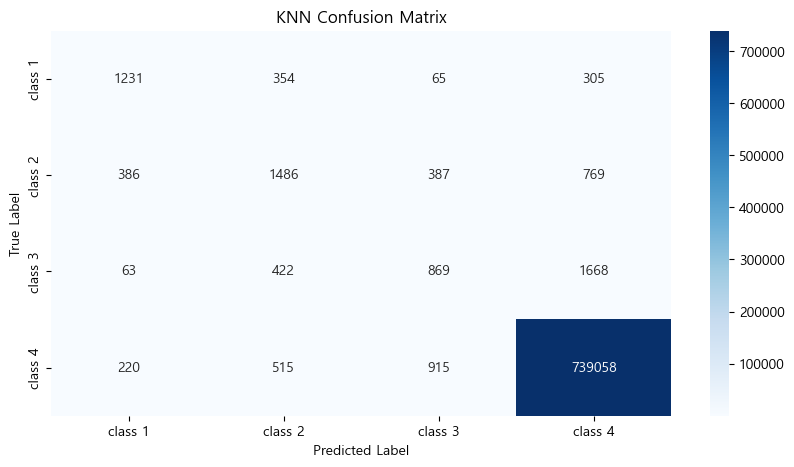

In [126]:
plt.figure(figsize=(10,5))

unique_value_list = []
unique_value = [1, 2, 3, 4]
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))

knn_cm = knn_cm_no_ws_deg
pred_labels = unique_value_list
sns.heatmap(knn_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [127]:
class_info(y_train, "test dataset")

[ test dataset의 class별 count / ratio ]
----------------------------------------
class 1: 5793 / 0.29%
class 2: 8799 / 0.44%
class 3: 8700 / 0.43%
class 4: 1983839 / 98.84%
----------------------------------------
안개 : 23292 / 1.16%


In [128]:
class_info(y_valid, "test dataset")

[ test dataset의 class별 count / ratio ]
----------------------------------------
class 1: 1955 / 0.26%
class 2: 3028 / 0.4%
class 3: 3022 / 0.4%
class 4: 740708 / 98.93%
----------------------------------------
안개 : 8005 / 1.07%


In [129]:
class_info(knn_test_pred_no_ws_deg, "test dataset")

[ test dataset의 class별 count / ratio ]
----------------------------------------
class 1: 594 / 0.23%
class 2: 1004 / 0.38%
class 3: 609 / 0.23%
class 4: 260593 / 99.16%
----------------------------------------
안개 : 2207 / 0.84%


In [130]:
pd.DataFrame(knn_test_pred_no_ws_deg).to_csv('knn_test_pred_no_ws_deg.csv') 